<a href="https://colab.research.google.com/github/Amendoza23N/DiplomadoUAS2025_andrei/blob/main/car_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. LIMPIEZA Y PRE-PROCESAMIENTO DE LOS DATOS

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
df = pd.read_csv('car_price_prediction.csv')

print("=== INFORMACIÓN INICIAL DEL DATASET ===")
print(f"Dimensiones: {df.shape}")
print(f"\nTipos de datos:\n{df.dtypes}")
print(f"\nValores nulos por columna:\n{df.isnull().sum()}")
print(f"\nEstadísticas descriptivas:\n{df.describe()}")

# Paso 1: Manejo de valores nulos
print("\n=== LIMPIEZA DE DATOS ===")

# Verificar valores únicos en Levy
print("Valores únicos en Levy:", df['Levy'].unique()[:10])

# Convertir Levy a numérico (manejar '-' como NaN)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

# Rellenar valores nulos en Levy con la mediana
levy_median = df['Levy'].median()
df['Levy'].fillna(levy_median, inplace=True)
print(f"Levy - Valores nulos después: {df['Levy'].isnull().sum()}")

# Paso 2: Limpiar y convertir columnas
# Limpiar Mileage (quitar 'km' y convertir a numérico)
df['Mileage'] = df['Mileage'].str.replace(' km', '').str.replace(',', '').astype(float)

# Limpiar Doors (tomar solo el primer número)
# Manejar el valor '>5' antes de la conversión a entero
df['Doors'] = df['Doors'].replace('>5', '5')
df['Doors'] = df['Doors'].str.split('-').str[0].astype(int)

# Limpiar Engine volume (quitar texto como ' Turbo', ' Hybrid' y convertir a numérico)
df['Engine volume'] = df['Engine volume'].astype(str).str.replace(' Turbo', '', regex=False)
df['Engine volume'] = df['Engine volume'].str.replace(' Hybrid', '', regex=False)
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')

# Rellenar valores nulos en Engine volume con la mediana
engine_volume_median = df['Engine volume'].median()
df['Engine volume'].fillna(engine_volume_median, inplace=True)
print(f"Engine volume - Valores nulos después: {df['Engine volume'].isnull().sum()}")

# Paso 3: Manejar valores atípicos en Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nRango de precios antes de limpiar outliers: {df['Price'].min()} - {df['Price'].max()}")
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]
print(f"Rango de precios después de limpiar outliers: {df['Price'].min()} - {df['Price'].max()}")

# Paso 4: Codificación de variables categóricas
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior',
                      'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print(f"\nDataset después de limpieza: {df.shape}")

=== INFORMACIÓN INICIAL DEL DATASET ===
Dimensiones: (19237, 18)

Tipos de datos:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

Valores nulos por columna:
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               

# 2. ANALISIS EXPLORATORIO DE LOS DATOS (EDA)


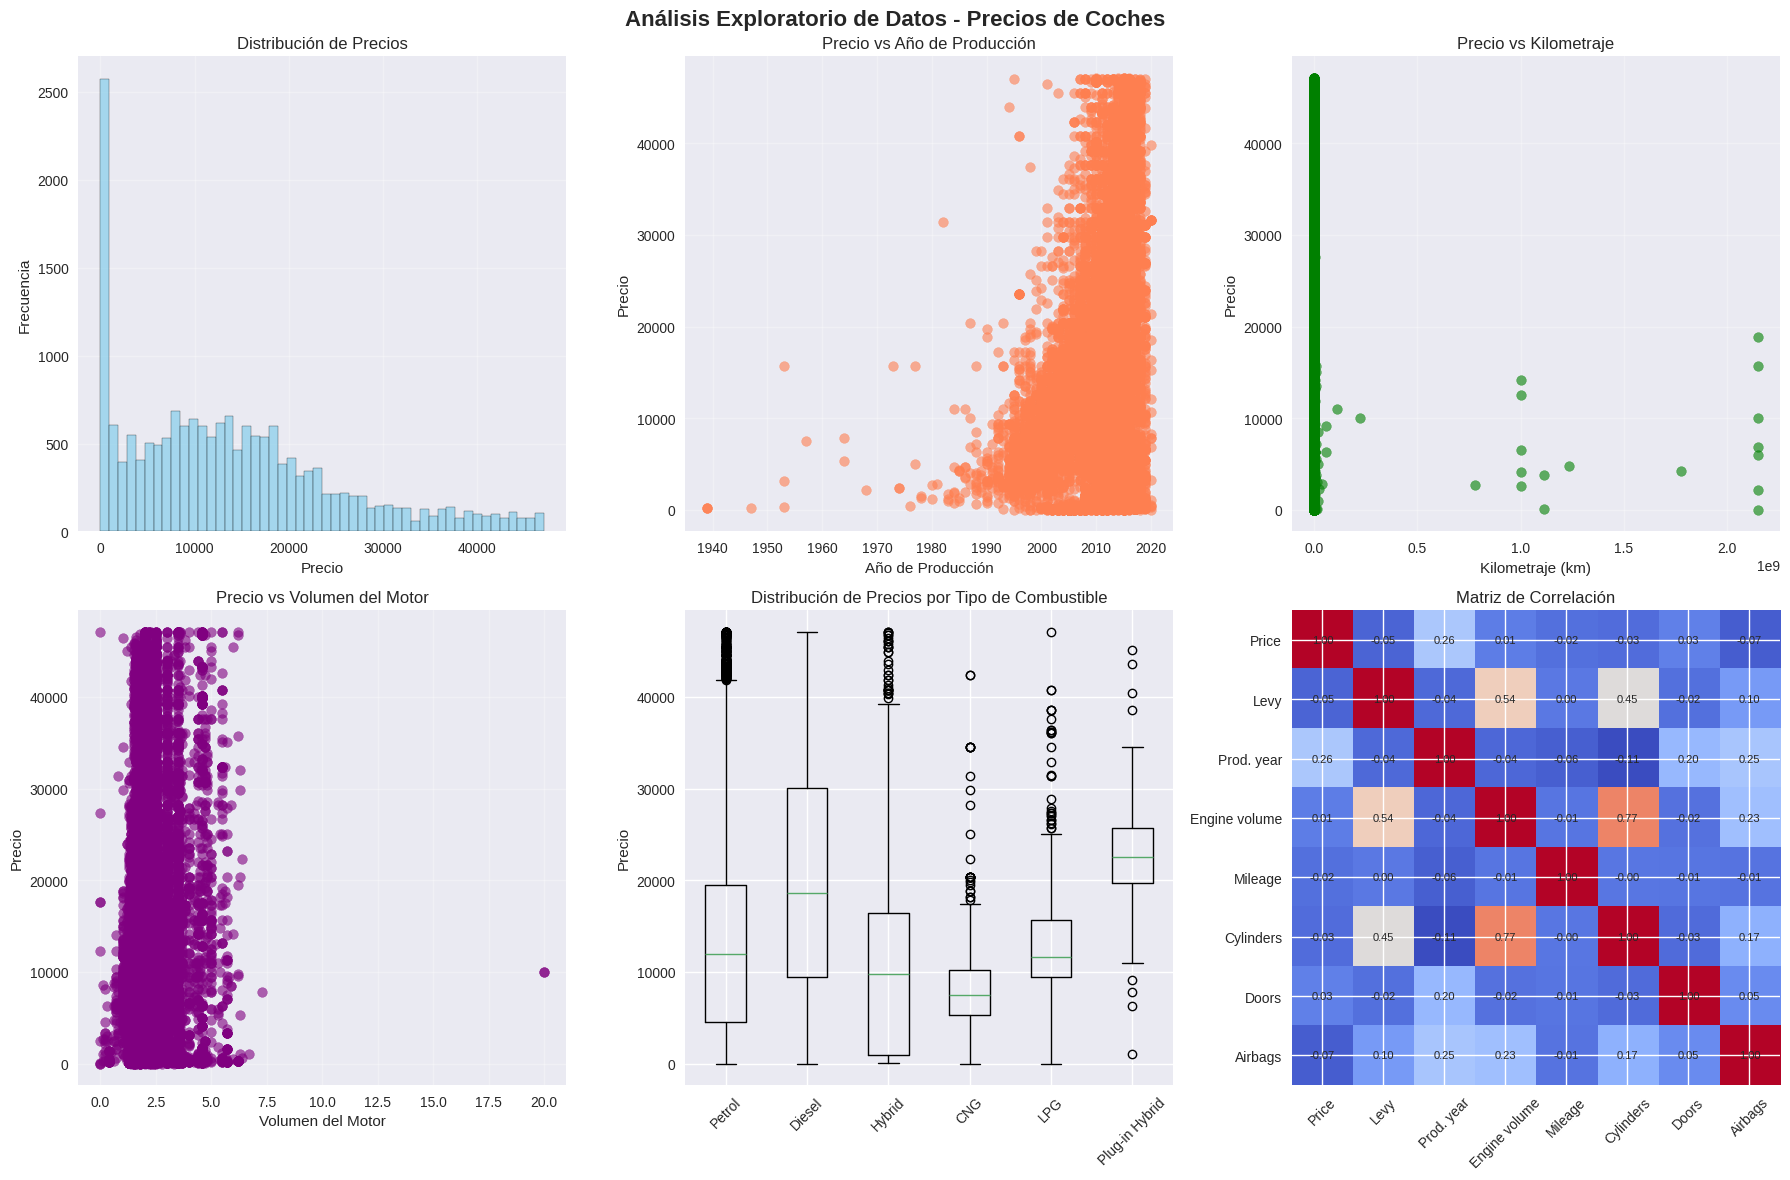

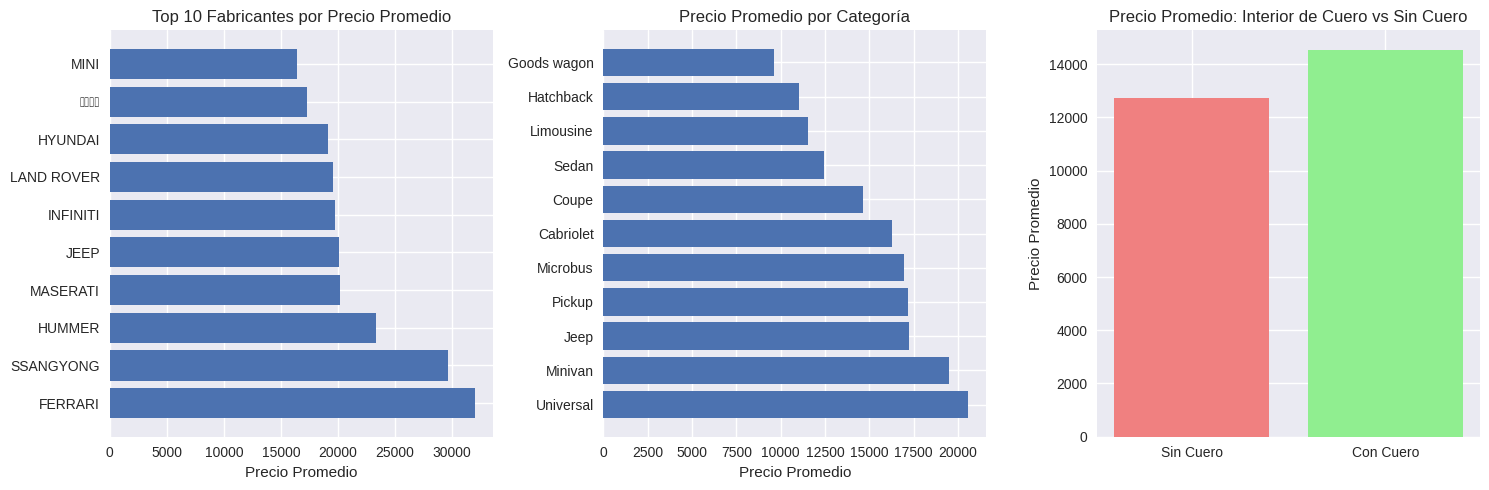

In [6]:
# Configuración de gráficos
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio de Datos - Precios de Coches', fontsize=16, fontweight='bold')

# Gráfico 1: Distribución de Precios
axes[0,0].hist(df['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribución de Precios')
axes[0,0].set_xlabel('Precio')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Precio vs Año de Producción
axes[0,1].scatter(df['Prod. year'], df['Price'], alpha=0.6, color='coral')
axes[0,1].set_title('Precio vs Año de Producción')
axes[0,1].set_xlabel('Año de Producción')
axes[0,1].set_ylabel('Precio')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Precio vs Kilometraje
axes[0,2].scatter(df['Mileage'], df['Price'], alpha=0.6, color='green')
axes[0,2].set_title('Precio vs Kilometraje')
axes[0,2].set_xlabel('Kilometraje (km)')
axes[0,2].set_ylabel('Precio')
axes[0,2].grid(True, alpha=0.3)

# Gráfico 4: Precio vs Volumen del Motor
axes[1,0].scatter(df['Engine volume'], df['Price'], alpha=0.6, color='purple')
axes[1,0].set_title('Precio vs Volumen del Motor')
axes[1,0].set_xlabel('Volumen del Motor')
axes[1,0].set_ylabel('Precio')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 5: Boxplot de Precio por Tipo de Combustible
fuel_price_data = []
fuel_types = ['Petrol', 'Diesel', 'Hybrid', 'CNG', 'LPG', 'Plug-in Hybrid']
for fuel in fuel_types:
    if fuel in label_encoders['Fuel type'].classes_:
        fuel_code = label_encoders['Fuel type'].transform([fuel])[0]
        prices = df[df['Fuel type'] == fuel_code]['Price']
        fuel_price_data.append(prices)

axes[1,1].boxplot(fuel_price_data, labels=fuel_types)
axes[1,1].set_title('Distribución de Precios por Tipo de Combustible')
axes[1,1].set_ylabel('Precio')
axes[1,1].tick_params(axis='x', rotation=45)

# Gráfico 6: Matriz de Correlación
numeric_columns = ['Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Doors', 'Airbags']
correlation_matrix = df[numeric_columns].corr()

im = axes[1,2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
axes[1,2].set_title('Matriz de Correlación')
axes[1,2].set_xticks(range(len(numeric_columns)))
axes[1,2].set_yticks(range(len(numeric_columns)))
axes[1,2].set_xticklabels(numeric_columns, rotation=45)
axes[1,2].set_yticklabels(numeric_columns)

# Añadir valores de correlación
for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        axes[1,2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Análisis adicional por categorías
plt.figure(figsize=(15, 5))

# Top 10 fabricantes por precio promedio
plt.subplot(1, 3, 1)
top_manufacturers = df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False).head(10)
plt.barh(range(len(top_manufacturers)), top_manufacturers.values)
plt.yticks(range(len(top_manufacturers)), [label_encoders['Manufacturer'].inverse_transform([x])[0] for x in top_manufacturers.index])
plt.title('Top 10 Fabricantes por Precio Promedio')
plt.xlabel('Precio Promedio')

# Precio promedio por categoría
plt.subplot(1, 3, 2)
category_prices = df.groupby('Category')['Price'].mean().sort_values(ascending=False)
plt.barh(range(len(category_prices)), category_prices.values)
plt.yticks(range(len(category_prices)), [label_encoders['Category'].inverse_transform([x])[0] for x in category_prices.index])
plt.title('Precio Promedio por Categoría')
plt.xlabel('Precio Promedio')

# Efecto del interior de cuero
plt.subplot(1, 3, 3)
leather_prices = df.groupby('Leather interior')['Price'].mean()
plt.bar(['Sin Cuero', 'Con Cuero'], leather_prices.values, color=['lightcoral', 'lightgreen'])
plt.title('Precio Promedio: Interior de Cuero vs Sin Cuero')
plt.ylabel('Precio Promedio')

plt.tight_layout()
plt.show()

# 3. ENTRENAMIENTO DEL MODELO MACHINE LEARNING


=== PREPARACIÓN PARA MODELO DE MACHINE LEARNING ===
Tamaño del conjunto de entrenamiento: (14531, 16)
Tamaño del conjunto de prueba: (3633, 16)

=== ENTRENANDO Random Forest ===
MAE: 3288.72
MSE: 31048714.11
RMSE: 5572.14
R²: 0.7542

=== ENTRENANDO Linear Regression ===
MAE: 8128.78
MSE: 106820384.57
RMSE: 10335.39
R²: 0.1543

=== COMPARACIÓN DE MODELOS ===
               Model          MAE          RMSE        R²
0      Random Forest  3288.721831   5572.137302  0.754177
1  Linear Regression  8128.779866  10335.394747  0.154267


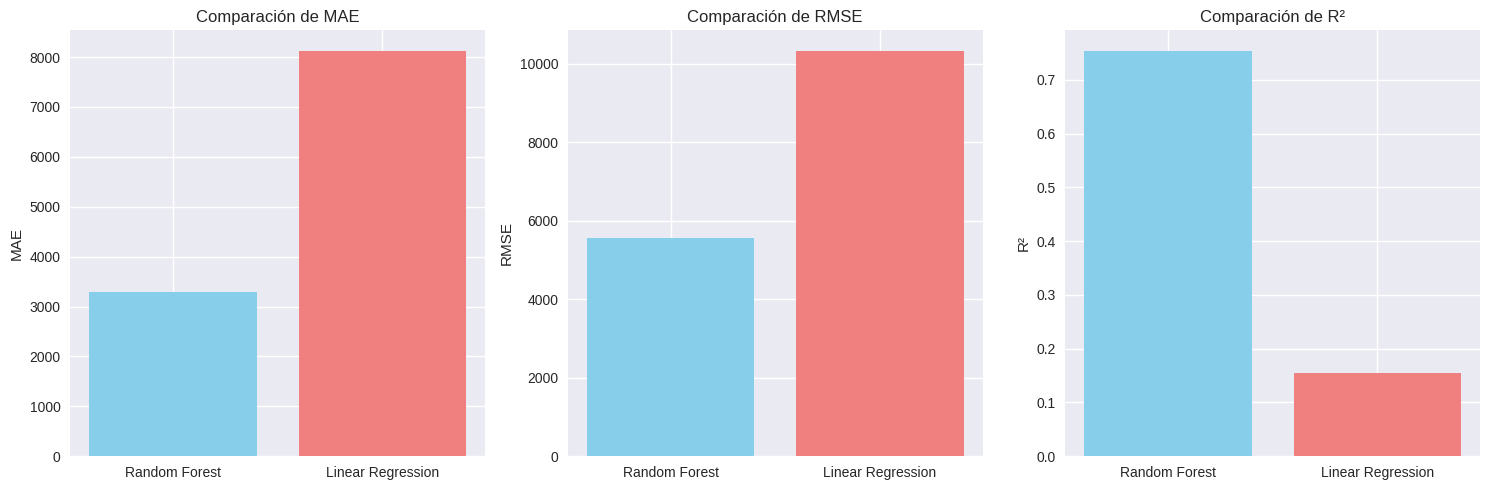

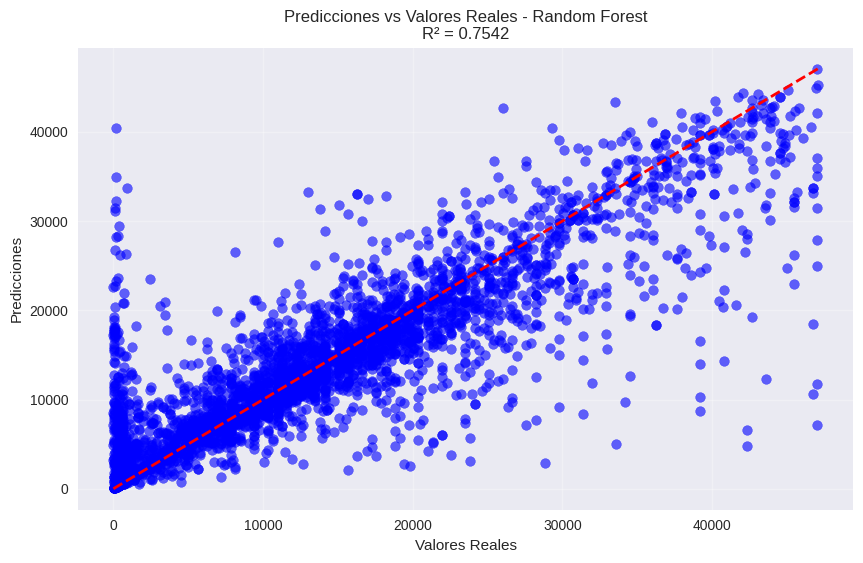

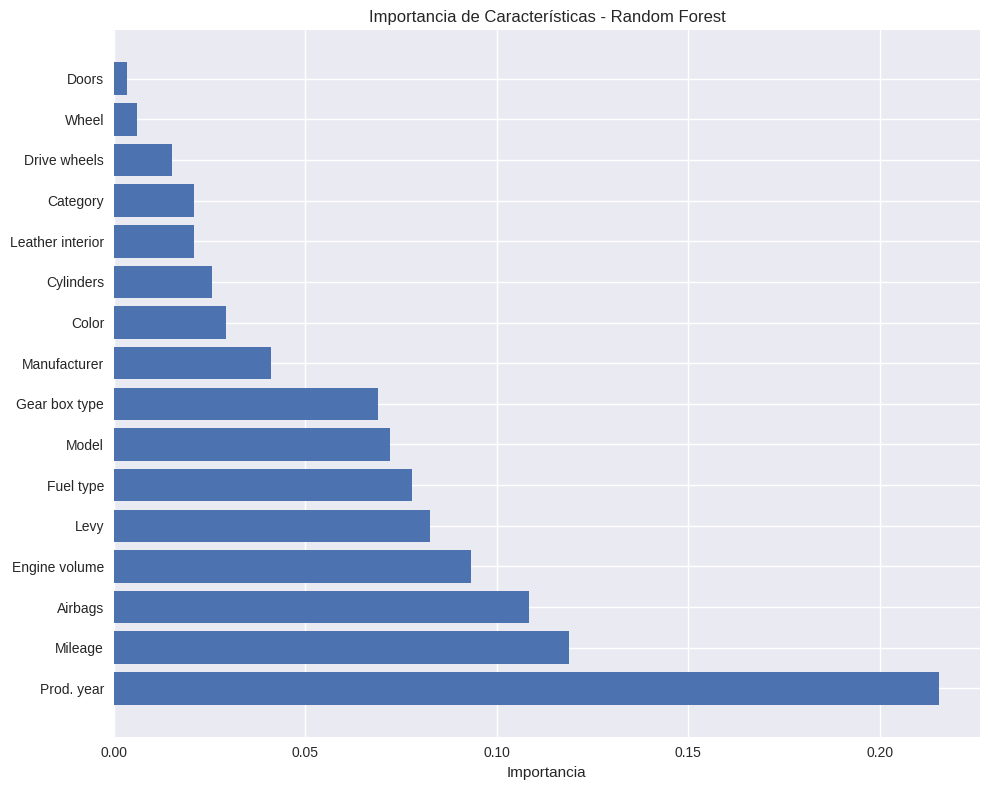


=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===
          Feature  Importance
3      Prod. year    0.215367
8         Mileage    0.118879
15        Airbags    0.108457
7   Engine volume    0.093326
0            Levy    0.082649
6       Fuel type    0.077808
2           Model    0.072159
10  Gear box type    0.068894
1    Manufacturer    0.041128
14          Color    0.029380


In [7]:
# Preparación de datos para el modelo
print("\n=== PREPARACIÓN PARA MODELO DE MACHINE LEARNING ===")

# Seleccionar características y variable objetivo
features = ['Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
            'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
            'Cylinders', 'Gear box type', 'Drive wheels', 'Doors',
            'Wheel', 'Color', 'Airbags']

X = df[features]
y = df['Price']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Escalar características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar diferentes modelos para comparación
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

results = {}

for name, model in models.items():
    print(f"\n=== ENTRENANDO {name} ===")

    # Entrenar modelo
    model.fit(X_train_scaled, y_train)

    # Predecir
    y_pred = model.predict(X_test_scaled)

    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'predictions': y_pred
    }

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

# Visualizar comparación de modelos
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
})

print("\n=== COMPARACIÓN DE MODELOS ===")
print(metrics_df)

# Gráfico de comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE
axes[0].bar(metrics_df['Model'], metrics_df['MAE'], color=['skyblue', 'lightcoral'])
axes[0].set_title('Comparación de MAE')
axes[0].set_ylabel('MAE')

# RMSE
axes[1].bar(metrics_df['Model'], metrics_df['RMSE'], color=['skyblue', 'lightcoral'])
axes[1].set_title('Comparación de RMSE')
axes[1].set_ylabel('RMSE')

# R²
axes[2].bar(metrics_df['Model'], metrics_df['R²'], color=['skyblue', 'lightcoral'])
axes[2].set_title('Comparación de R²')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales (mejor modelo)
best_model_name = max(results, key=lambda x: results[x]['R²'])
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Predicciones vs Valores Reales - {best_model_name}\nR² = {results[best_model_name]["R²"]:.4f}')
plt.grid(True, alpha=0.3)
plt.show()

# Análisis de importancia de características (solo para Random Forest)
if best_model_name == 'Random Forest':
    feature_importance = models[best_model_name].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('Importancia de Características - Random Forest')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()

    print("\n=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===")
    print(feature_importance_df.head(10))

# EXPLICACION DE LOS RESULTADOS


In [8]:
print("\n" + "="*60)
print("CONCLUSIONES Y EXPLICACIÓN DE RESULTADOS")
print("="*60)

print(f"\n1. MEJOR MODELO: {best_model_name}")
print(f"   - R² Score: {results[best_model_name]['R²']:.4f}")
print(f"   - Error absoluto promedio: ${results[best_model_name]['MAE']:.2f}")
print(f"   - Error cuadrático medio: ${results[best_model_name]['RMSE']:.2f}")

print(f"\n2. POR QUÉ ELEGÍ RANDOM FOREST:")
print("   - Maneja bien relaciones no lineales entre variables")
print("   - Robustez ante outliers")
print("   - No requiere normalización estricta de datos")
print("   - Proporciona importancia de características")
print("   - Buen rendimiento con datos tabulares")

print(f"\n3. HALLazgos PRINCIPALES DEL EDA:")
print("   - El año de producción tiene correlación positiva con el precio")
print("   - El kilometraje tiene correlación negativa con el precio")
print("   - Los vehículos con interior de cuero tienden a ser más caros")
print("   - Existen diferencias significativas entre categorías de vehículos")

print(f"\n4. RECOMENDACIONES PARA MEJORAR EL MODELO:")
print("   - Recolectar más datos de modelos específicos")
print("   - Incluir información sobre el estado del vehículo")
print("   - Considerar variables de ubicación geográfica")
print("   - Experimentar con modelos más complejos (XGBoost, Neural Networks)")


CONCLUSIONES Y EXPLICACIÓN DE RESULTADOS

1. MEJOR MODELO: Random Forest
   - R² Score: 0.7542
   - Error absoluto promedio: $3288.72
   - Error cuadrático medio: $5572.14

2. POR QUÉ ELEGÍ RANDOM FOREST:
   - Maneja bien relaciones no lineales entre variables
   - Robustez ante outliers
   - No requiere normalización estricta de datos
   - Proporciona importancia de características
   - Buen rendimiento con datos tabulares

3. HALLazgos PRINCIPALES DEL EDA:
   - El año de producción tiene correlación positiva con el precio
   - El kilometraje tiene correlación negativa con el precio
   - Los vehículos con interior de cuero tienden a ser más caros
   - Existen diferencias significativas entre categorías de vehículos

4. RECOMENDACIONES PARA MEJORAR EL MODELO:
   - Recolectar más datos de modelos específicos
   - Incluir información sobre el estado del vehículo
   - Considerar variables de ubicación geográfica
   - Experimentar con modelos más complejos (XGBoost, Neural Networks)
